# Problem Statement

Predicting effective treatmens for diabetes for reducing the readmission into the hospital


# Introduction
In this project I will try to predict the effect of the treatments on readmissions.

* data exploration
* feature engineering
* building training/test samples
* model selection
* model evaluation


# Data Exploration 

The data that is used in here originally comes from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008).


In [1]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt

In [2]:
# load the csv file
df = pd.read_csv('diabetic_data.csv')

In [3]:
print('Number of samples:',len(df))

Number of samples: 101766


In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
df.shape

(101766, 50)

## Check duplicated values

Here I checked duplicated values by patient_number, probably this data wont help us for prediction, maybe better to delete.

In [6]:
# Checks duplicated values
# df.dropna(inplace = True)
print('Total data = ', len(df))
print('Unique entries = ', len(np.unique(df['patient_nbr'])))

Total data =  101766
Unique entries =  71518


In [7]:
# delete duplicated values, but not now
# df.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
# print('After remove duplicates:', len(df))

## Missing Values

Here we investigate missing values in all data set by attributes. With this way we can say which attribute can be valuable for pur prediction.

In [8]:
t = PrettyTable(['Column Name', 'Missing Values', 'Missing Percentage'])
for col in df.columns :
    lenn = len(df[df[col] == '?'])
    t.add_row([col,lenn,lenn / len(df)])
print(t)

/Users/tugcekonuklar/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


+--------------------------+----------------+-----------------------+
|       Column Name        | Missing Values |   Missing Percentage  |
+--------------------------+----------------+-----------------------+
|       encounter_id       |       0        |          0.0          |
|       patient_nbr        |       0        |          0.0          |
|           race           |      2273      |  0.022335554114340742 |
|          gender          |       0        |          0.0          |
|           age            |       0        |          0.0          |
|          weight          |     98569      |   0.9685847925633315  |
|    admission_type_id     |       0        |          0.0          |
| discharge_disposition_id |       0        |          0.0          |
|   admission_source_id    |       0        |          0.0          |
|     time_in_hospital     |       0        |          0.0          |
|        payer_code        |     40256      |   0.395574160328597   |
|    medical_special

### Handling Missing values

"payer_code", "medical_specialty" and "weight" atributes have more that %40 missing values and thats why we can drop those columns.

In [9]:
df = df.drop(['medical_specialty','payer_code','weight'],axis=1)

For the other attributes that has missing value , lets replace ? values with NAN 

and race info missing values ratio is so low and filled with mode wont effect the results, in this case will be replace with "Caucasian".


In [10]:
df['race']=df.race.replace('?',np.nan)
df['race'].fillna(df['race'].mode()[0], inplace=True)
df['diag_1']=df.diag_1.replace('?',np.nan)
df['diag_2']=df.diag_2.replace('?',np.nan)
df['diag_3']=df.diag_3.replace('?',np.nan)

### Filtering Data

Here we will filter some data which wont be usefull for our readmissinon calculation. 

Filtering patients with Diabetes, who uses the medician



In [11]:
df=df[df.diabetesMed=='Yes']
df.shape

(78363, 47)

Filtering patients who didn't readmit, means healed , that we dont need to include the data set.

In [12]:
df=df[df.readmitted=='NO']
df.shape

(40934, 47)

We will exclude patients who are Dead and are in hospise

In [13]:
df=df[~df.discharge_disposition_id.isin([11,13,14,19,20])]
df.shape


(39355, 47)

# Feature Engineering

Here we see on data there are 23 Drugs which is using to heal diabetes. We seperate 3 category 
**insulin , insulin and others , others** and try understnad which threathment is effective.

In [14]:
treatments = df[['encounter_id','metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']].copy()

In [15]:
treatments.head()

,encounter_id,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
2,64410,No,No,No,No,No,No,Steady,No,No,...,No,No,No,No,No,No,No,No,No,No
3,500364,No,No,No,No,No,No,No,No,No,...,No,No,No,No,Up,No,No,No,No,No
4,16680,No,No,No,No,No,No,Steady,No,No,...,No,No,No,No,Steady,No,No,No,No,No
6,55842,Steady,No,No,No,Steady,No,No,No,No,...,No,No,No,No,Steady,No,No,No,No,No
8,12522,No,No,No,No,No,No,Steady,No,No,...,No,No,No,No,Steady,No,No,No,No,No


To see how many different drug used to heal, we decide to create some custome encodes.

In [16]:
treatments=treatments.replace(['No','Steady','Up','Down'],[0,1,1,1])
treatments.set_index('encounter_id',inplace=True)

In [17]:
treatments.head()

,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,...,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone
encounter_id,,,,,,,,,,,,,,,,,,,,,
64410,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
500364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
16680,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
55842,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
12522,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [18]:
treatments.sum(axis=1).value_counts()

1    23080
2    11397
3     4108
4      730
5       39
6        1
dtype: int64

Here we ssee max 6 combination of drugs given a patient.

#### Creating new attribute "Treatments"

Here we will categorise patiend as "insilun", "insilun and other" and "others" in "treathments" attributes

In [19]:
## When the value insulin=1, then we label insilun category and insilun and others 
insulin = treatments[treatments['insulin']==1].sum(axis = 1).replace([1,2,3,4,5,6],['insulin','insulin and other','insulin and other','insulin and other','insulin and other','insulin and other'])

In [20]:
insulin.value_counts()

insulin              14675
insulin and other    12145
dtype: int64

In [21]:
## When insilun=0, then needs to be others or no medical treathment
noInsulin = treatments[treatments['insulin']==0].sum(axis=1).replace([0,1,2,3,4,5,6],['no med','other','other','other','other','other','other'])

In [22]:
noInsulin.value_counts()

other    12535
dtype: int64

In [23]:
treatments=pd.concat([insulin,noInsulin])
treatments = pd.DataFrame({'treatments':treatments})

In [24]:
treatments.head()

,treatments
encounter_id,
500364,insulin
16680,insulin and other
55842,insulin and other
12522,insulin and other
15738,insulin and other


### Add new feature in actual data set 

we add treatments column in data set by indexing with encounter_id column

In [25]:
df=df.join(treatments,on="encounter_id")

In [26]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,treatments
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,Yes,NO,other
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,Up,No,No,No,No,No,Ch,Yes,NO,insulin
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,Steady,No,No,No,No,No,Ch,Yes,NO,insulin and other
6,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,70,...,Steady,No,No,No,No,No,Ch,Yes,NO,insulin and other
8,12522,48330783,Caucasian,Female,[80-90),2,1,4,13,68,...,Steady,No,No,No,No,No,Ch,Yes,NO,insulin and other


### Convert nonnumeric attributes to numeric one


Now we have "age" ordinal feature, we should convert to numeric 

In [27]:
df.age.value_counts()

[70-80)     9646
[60-70)     8963
[50-60)     7209
[80-90)     5873
[40-50)     3941
[30-40)     1558
[90-100)    1000
[20-30)      696
[10-20)      363
[0-10)       106
Name: age, dtype: int64

In [28]:
df["age"].isnull().sum()

0

In [29]:
# labels = df['age'].astype('category').cat.categories.tolist()
# replace_age = {'age' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
# print(replace_age)
age_id = {'[0-10)':5, 
          '[10-20)':15, 
          '[20-30)':25, 
          '[30-40)':35, 
          '[40-50)':45, 
          '[50-60)':55,
          '[60-70)':65, 
          '[70-80)':75, 
          '[80-90)':85, 
          '[90-100)':95}

In [30]:
df.age.replace(age_id, inplace=True)

In [31]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,treatments
2,64410,86047875,AfricanAmerican,Female,25,1,1,7,2,11,...,No,No,No,No,No,No,No,Yes,NO,other
3,500364,82442376,Caucasian,Male,35,1,1,7,2,44,...,Up,No,No,No,No,No,Ch,Yes,NO,insulin
4,16680,42519267,Caucasian,Male,45,1,1,7,1,51,...,Steady,No,No,No,No,No,Ch,Yes,NO,insulin and other
6,55842,84259809,Caucasian,Male,65,3,1,2,4,70,...,Steady,No,No,No,No,No,Ch,Yes,NO,insulin and other
8,12522,48330783,Caucasian,Female,85,2,1,4,13,68,...,Steady,No,No,No,No,No,Ch,Yes,NO,insulin and other


## Filtering other treathments 

We try to prove to show insulin and insulin $ other treatments power thats why we exclude only "other" treathment.
Choosing the records with treatments Insulin and Insulin + other ( w.r.t Problem Statement)

In [32]:
df=df[df.treatments!='other']
df.shape

(26820, 48)

#### Convert category data

To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the get_dummies function.


In [33]:
df = pd.get_dummies(df, columns=['race', 'gender','max_glu_serum', 'A1Cresult', 'change',
       'diabetesMed', 'readmitted'])

In [34]:
df.head()

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_Yes,readmitted_NO
3,500364,82442376,35,1,1,7,2,44,1,16,...,1,0,0,0,1,0,1,0,1,1
4,16680,42519267,45,1,1,7,1,51,0,8,...,1,0,0,0,1,0,1,0,1,1
6,55842,84259809,65,3,1,2,4,70,1,21,...,1,0,0,0,1,0,1,0,1,1
8,12522,48330783,85,2,1,4,13,68,2,28,...,1,0,0,0,1,0,1,0,1,1
9,15738,63555939,95,3,3,4,12,33,3,18,...,1,0,0,0,1,0,1,0,1,1


### Dropping unused columns

Since the treatments column was created from the 23 Drugs, We will be removing them

In [35]:
df = df.drop(['metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],axis=1)

In [36]:
df.head()

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_Yes,readmitted_NO
3,500364,82442376,35,1,1,7,2,44,1,16,...,1,0,0,0,1,0,1,0,1,1
4,16680,42519267,45,1,1,7,1,51,0,8,...,1,0,0,0,1,0,1,0,1,1
6,55842,84259809,65,3,1,2,4,70,1,21,...,1,0,0,0,1,0,1,0,1,1
8,12522,48330783,85,2,1,4,13,68,2,28,...,1,0,0,0,1,0,1,0,1,1
9,15738,63555939,95,3,3,4,12,33,3,18,...,1,0,0,0,1,0,1,0,1,1


In [37]:
df.columns

Index(['encounter_id', 'patient_nbr', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'treatments',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Female', 'gender_Male', 'max_glu_serum_>200',
       'max_glu_serum_>300', 'max_glu_serum_None', 'max_glu_serum_Norm',
       'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm',
       'change_Ch', 'change_No', 'diabetesMed_Yes', 'readmitted_NO'],
      dtype='object')

In [38]:
df = df.drop(['diag_1','diag_2','diag_3'],axis = 1)

### Corrolation between features

The input variables are both Discrete Quantitative and Categorical and our output variable is Categorical.
Since we have a combination of Discrete Quantitative Variables and Categorical Variables, we cannot perform general Correlation tests. We will run Chi-Square Test

In [39]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [40]:
df['dummyCat'] = np.random.choice([0, 1], size=(len(df),), p=[0.5, 0.5])

df.dummyCat.value_counts()

0    13440
1    13380
Name: dummyCat, dtype: int64

In [41]:
#Initialize ChiSquare Class
cT = ChiSquare(df)

#Feature Selection
testColumns = ['encounter_id', 'patient_nbr', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Female', 'gender_Male',
       'max_glu_serum_>200', 'max_glu_serum_>300', 'max_glu_serum_None',
       'max_glu_serum_Norm', 'A1Cresult_>7', 'A1Cresult_>8', 'A1Cresult_None',
       'A1Cresult_Norm', 'change_Ch', 'change_No', 'diabetesMed_Yes',
       'readmitted_NO', 'dummyCat']
for var in testColumns:
    cT.TestIndependence(colX=var,colY="treatments" ) 

encounter_id is NOT an important predictor. (Discard encounter_id from model)
patient_nbr is NOT an important predictor. (Discard patient_nbr from model)
age is IMPORTANT for Prediction
admission_type_id is IMPORTANT for Prediction
discharge_disposition_id is IMPORTANT for Prediction
admission_source_id is IMPORTANT for Prediction
time_in_hospital is IMPORTANT for Prediction
num_lab_procedures is NOT an important predictor. (Discard num_lab_procedures from model)
num_procedures is IMPORTANT for Prediction
num_medications is IMPORTANT for Prediction
number_outpatient is NOT an important predictor. (Discard number_outpatient from model)
number_emergency is NOT an important predictor. (Discard number_emergency from model)
number_inpatient is IMPORTANT for Prediction
number_diagnoses is IMPORTANT for Prediction
race_AfricanAmerican is IMPORTANT for Prediction
race_Asian is NOT an important predictor. (Discard race_Asian from model)
race_Caucasian is IMPORTANT for Prediction
race_Hispanic i

In [42]:
df.shape

(26820, 35)

In [43]:
df.columns

Index(['encounter_id', 'patient_nbr', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'treatments', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Female',
       'gender_Male', 'max_glu_serum_>200', 'max_glu_serum_>300',
       'max_glu_serum_None', 'max_glu_serum_Norm', 'A1Cresult_>7',
       'A1Cresult_>8', 'A1Cresult_None', 'A1Cresult_Norm', 'change_Ch',
       'change_No', 'diabetesMed_Yes', 'readmitted_NO', 'dummyCat'],
      dtype='object')

# Building Traning/Test Samples

Since our target variable is Categorical , We would be importing the required Classification model packages

We found not important corrolated columns by usinf Chi-Square alg and we will drop unnecessary columns from dataset while running our models.

In [45]:
X = df.drop(['encounter_id','patient_nbr','num_lab_procedures','number_outpatient','number_emergency',
                      'race_Asian','race_Other','diabetesMed_Yes','max_glu_serum_>200','A1Cresult_>8','A1Cresult_Norm',
                      'readmitted_NO','dummyCat','treatments'],axis=1)
Y = df['treatments']

print(X.shape)
print(Y.shape)

(26820, 21)
(26820,)


In [46]:
# to see columns between 10:20 

X[list(X.columns)[:10]].head()

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_procedures,num_medications,number_inpatient,number_diagnoses,race_AfricanAmerican
3,35,1,1,7,2,1,16,0,7,0
4,45,1,1,7,1,0,8,0,5,0
6,65,3,1,2,4,1,21,0,7,0
8,85,2,1,4,13,2,28,0,8,0
9,95,3,3,4,12,3,18,0,8,0


Now we will build train and test set with %30 test size with random state 2 

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18774, 21), (8046, 21), (18774,), (8046,))

In [48]:
y_p=[]
for i in range(y_test.shape[0]):
    y_p.append(y_test.mode()[0])#Highest class is assigned to a list which is compared with ytest
len(y_p)

8046

In [49]:
y_pred=pd.Series(y_p)


In [50]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
print("Accuracy : ",accuracy_score(y_test,y_pred))


Accuracy :  0.5437484464330102


our baseline accurency is 0.54 (%54), then we should find better model 

### 1- Decision Trees


In [51]:
from sklearn.tree import DecisionTreeClassifier


m4 = DecisionTreeClassifier()
m4.fit(X_train,y_train)
y_pred_dt=m4.predict(X_test)
Train_Score_dt = m4.score(X_train,y_train)
Test_Score_dt = accuracy_score(y_test,y_pred_dt)

print('Training Accuracy :',Train_Score_dt)
print('Testing Accuracy :',Test_Score_dt)
print(classification_report(y_test,y_pred_dt))

Training Accuracy : 0.9965910301480772
Testing Accuracy : 0.699602286850609
                   precision    recall  f1-score   support

          insulin       0.72      0.74      0.73      4375
insulin and other       0.68      0.65      0.66      3671

        micro avg       0.70      0.70      0.70      8046
        macro avg       0.70      0.70      0.70      8046
     weighted avg       0.70      0.70      0.70      8046



### 2- Random Forest


In [52]:
from sklearn.ensemble import RandomForestClassifier

m5 = RandomForestClassifier()
m5.fit(X_train,y_train)
y_pred_rf=m5.predict(X_test)
Train_Score_rf = m5.score(X_train,y_train)
Test_Score_rf = accuracy_score(y_test,y_pred_rf)

print('Training Accuracy :',Train_Score_rf)
print('Testing Accuracy :',Test_Score_rf)
print(classification_report(y_test,y_pred_rf))

/Users/tugcekonuklar/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Accuracy : 0.9863108554383723
Testing Accuracy : 0.7327864777529207
                   precision    recall  f1-score   support

          insulin       0.77      0.72      0.75      4375
insulin and other       0.69      0.74      0.72      3671

        micro avg       0.73      0.73      0.73      8046
        macro avg       0.73      0.73      0.73      8046
     weighted avg       0.74      0.73      0.73      8046



In [53]:
df=df[df.treatments!='other']
df.shape

(26820, 35)

In [54]:
df.age.value_counts()

75    6171
65    5982
55    4986
85    3834
45    2860
35    1226
95     677
25     630
15     348
5      106
Name: age, dtype: int64

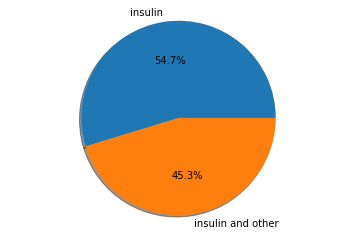

In [56]:
labels = df['treatments'].astype('category').cat.categories.tolist()
counts = df['treatments'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

In [57]:
df.head()

,encounter_id,patient_nbr,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,change_Ch,change_No,diabetesMed_Yes,readmitted_NO,dummyCat
3,500364,82442376,35,1,1,7,2,44,1,16,...,0,0,0,1,0,1,0,1,1,0
4,16680,42519267,45,1,1,7,1,51,0,8,...,0,0,0,1,0,1,0,1,1,1
6,55842,84259809,65,3,1,2,4,70,1,21,...,0,0,0,1,0,1,0,1,1,0
8,12522,48330783,85,2,1,4,13,68,2,28,...,0,0,0,1,0,1,0,1,1,1
9,15738,63555939,95,3,3,4,12,33,3,18,...,0,0,0,1,0,1,0,1,1,0


In [64]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.display import display

from sklearn.tree import export_graphviz
import graphviz


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:

dot_data = export_graphviz(
    m4,
    out_file=None,
    feature_names=X.columns,
    class_names=['insulin', 'Insulin+others'],
    filled=True,
    rounded=True,
    special_characters=True)
graph = graphviz.Source(dot_data)
graph


ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH